
<img src="http://www.houseofbots.com/images/news/1442/cover.png" width="600">

The field of deep learning is frequently described as a mix of art and science.  One of the most "art-sy" parts of the field, in my experience, is the subject of network topology design - i.e., choosing the right geometry, size, depth, and type of the network.  

Machine learning practitioners develop rules of thumb for reasonable starting points - and learn heuristics for how to iterate towards optimality.  

In this post, I'll walk you through my early exploration with [talos](https://github.com/autonomio/talos), a simple framework that automates the workflow of conducting hyperparameter optimization on `keras` models.  I'm relatively new to `talos` so this brief tutorial should be no substitute for the [project's documentation](https://autonomio.github.io/docs_talos/#introduction) or [support forum](https://spectrum.chat/talos).  

As a sample dataset, I'll make use of data from a recent contest at [`numerai`](https://numer.ai/homepage), an interesting project that is best thought of as Kaggle, Quantopian, and ethereum all rolled into one.  

Numerai provides datasets to any data scientists interested in developing prediction models - much like Kaggle.  Those who feel they have trained useful models can choose to enter a weekly contest for a chance to win cash prizes.  

To access this sample dataset, I'll make use of [Numerox](https://github.com/kwgoodman/numerox/tree/master/numerox), an API interface to numerai's data contests. 

This post will cover: 
* Installing `talos` and `numerox` 
* Downloading and preparing data from numerai
* Setting up and executing a coarse parameter sweep on a `keras` model
* Analyzing the results
* Conducting a second, more "fine" scan on the parameter space
* Reaching a final model

If you'd like to replicate and experiment with the below code, _you can download the source notebook for this post by right-clicking on the below button and choosing "save link as"_ 

<a style="text-align: center;" href="https://github.com/convergenceIM/alpha-scientist/blob/master/content/talos_post.ipynb"><img src="images/button_ipynb-notebook.png" title="download ipynb" /></a>

## Setup and Download
Setting up `talos` and `numerox` are straight forward:

`pip install talos`

`pip install numerox`

 Here we'll use it only to download and separate the provided `train` and `validation` sets.  Note there are also `test` and `live` sets but those are unlabeled so not of use for present purposes.

In [1]:
## install packages if necessary
# %%capture
# !pip install numerox
# !pip install talos

import numerox as nx
import talos as ta

import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


First we will download and unpack the most recent dataset from Numerai into DataFrame formats:

In [2]:
data = nx.download('numerai_dataset.zip')

train_df = data['train'].df
val_df = data['validation'].df

print(train_df.head())

numerai_dataset.zip: 100%|█████████████████▉| 160M/161M [00:15<00:00, 10.4MB/s]

                  era  region       x1       x2       x3       x4       x5  \
id                                                                           
n0003126ff2349f6  1.0     0.0  0.54836  0.31077  0.37524  0.49490  0.53217   
n003d773d29b57ec  1.0     0.0  0.34712  0.40275  0.42747  0.44006  0.47866   
n0074df2dc6810b6  1.0     0.0  0.50871  0.48639  0.47544  0.40306  0.53436   
n0090630f530903e  1.0     0.0  0.61363  0.40268  0.53779  0.37045  0.58711   
n00af19089546fe9  1.0     0.0  0.30704  0.47273  0.54495  0.48692  0.47348   

                       x6       x7       x8   ...         x48      x49  \
id                                            ...                        
n0003126ff2349f6  0.48388  0.50220  0.59506   ...     0.55239  0.64054   
n003d773d29b57ec  0.44055  0.59182  0.68856   ...     0.46029  0.62941   
n0074df2dc6810b6  0.64028  0.51420  0.63232   ...     0.40596  0.54731   
n0090630f530903e  0.59900  0.62428  0.73602   ...     0.53878  0.47776   
n00af1908

numerai_dataset.zip: 161MB [00:30, 10.4MB/s]                                   

Looking inside of one of these dataframes, you'll note a few things:
1. The last several columns are named 'bernie', 'elizabeth' etc...  These are codenames for different outcome variables the data can be used to predict.  The key point is that each of these outcomes is independent of each other (not a multi-class problem, instead several one-class problems).  
2. The features are labeled as only `x1` to `x50`, not with names that provide any hint to what they represent.  This is by design - part of numerai's approach to abstracting real financial market data into 100% data science, 0% market knowledge.  
3. The features have already been scaled and standardized.  Allegedly, the data has also been carefully cleansed as well.  

Next, we'll define a simple function to split each dataframe into features (X), labels (y), and two other series `regions` and `eras` which we will discard (they are not available on the out of sample data, so we definitely don't want to train models using them!)

We'll choose one target variable to use as our target label.  Here, I'll choose `elizabeth`. 


In [8]:
## prepare data for training
def prepare_subset(df,target):
    ''' Returns X (dataframe or array) and y (series or array) for a given target'''
    tmp = df.iloc[:,2:52].join(df[target]).dropna()
    X = tmp.iloc[:,:-1]
    y = tmp.iloc[:,-1]
    eras = tmp.iloc[:,0]
    regions = tmp.iloc[:,1]
    
    return X,y,regions,eras

target_outcome = 'elizabeth'

X_train,y_train,regions,eras = prepare_subset(train_df,target_outcome)
X_val,y_val,regions,eras = prepare_subset(val_df,target_outcome)

Now that we have data, I'll train a very basic logistic regression model to serve as baseline:

In [14]:
clf =LogisticRegression()
clf.fit(X_train,y_train)
y_train_proba = clf.predict_proba(X_train)
y_val_proba = clf.predict_proba(X_val)

from sklearn.metrics import log_loss

# baseline

base_loss = log_loss(y_true=y_train,y_pred=pd.Series(0.5,index=y_train.index))
train_loss = log_loss(y_true=y_train,y_pred=y_train_proba)
val_loss = log_loss(y_true=y_val,y_pred=y_val_proba)

base_acc = clf.score(X_train,pd.Series(1,index=y_train.index))
train_acc = clf.score(X_train,y_train)
val_acc = clf.score(X_val,y_val)

print(f"Baseline Log-Loss (guess 0.5): {base_loss}")
print(f"Training Loss: {train_loss}")
print(f"Validation Loss: {val_loss}")

print()
print('Accuracy Values:')
print(f"Training Accuracy: {train_acc}")
print(f"Validation Loss: {val_acc}")

Baseline Log-Loss (guess 0.5): 0.6931471805599451
Training Loss: 0.692173949121537
Validation Loss: 0.6926950114467703

Accuracy Values:
Training Accuracy: 0.517007073351209
Validation Loss: 0.5121603309321732


I've calculated the log-loss values and class accuracies for training and validation sets, as well as for a naive strategy of always guessing 50%.  You'll note that the model has learned _something_ but not all that much.  

This is the unfortunate reality of using machine learning to predict financial markets.  Edge exists, but it is _very, very slight_.  There is also an upside in this reality.  

Achieving a model which truly offers 51% (or better yet, 52/53/54%) accuracy out of sample can potentially be extraordinarily profitable, given highly liquid markets and careful attention to transaction costs.  And the reward for moving from 51/49 advantage to 52/48 is a doubling** in potential profit.   
_** actually more than double, when considering transaction costs_

If we wanted to improve upon this result with a "representation" model, there would be any number of tactics to employ.  However, since the purpose of this post is to explore hyperparameter optimization of keras models, I won't bother.     

## Enter, Talos...
<img src="https://raw.githubusercontent.com/autonomio/hyperio/master/logo.png" width="300">


At this point, you may want to take a minute or two to read the [talos docs](https://autonomio.github.io/docs_talos/#introduction) and [example notebooks](https://github.com/autonomio/talos#Examples).  

TL;DR: essentially a talos workflow involves (1) creating a dict of parameter values to evaluate, (2) defining your keras model within a `build_model` as you may already do, but with a few small modifications in format, and (3) running a "Scan" method. 

_Warning: the below code could take 60 minutes+ to execute.  It took me about __80 minutes on a Tesla K80 GPU__.  If you want to replicate results and are concerned about compute time, speed things up by:_ 
1. reducing/changing parameter values - especially `epoch` and `batch_size`
2. setting the `grid_downsample` value to something less than 1.00 which runs a random subset of possible combinations, or
3. Adjusting the `early_stopper` settings (namely reducing the `patience` metric to cause the training to stop more quickly after low-water-mark is reached)

In [1]:
#from keras import models
#from keras import layers

from keras.models import Sequential
from keras.layers import Dropout, Dense
from keras.callbacks import TensorBoard
from talos.model.early_stopper import early_stopper

# track performance on tensorboard
tensorboard = TensorBoard(log_dir='./logs',
                 histogram_freq=0,batch_size=5000,
                 write_graph=False, 
                 write_images=False)


# (1) Define dict of parameters to try
p = {'first_neuron':[10, 40, 160, 640, 1280],
     'hidden_neuron':[10, 40, 160],
     'hidden_layers':[0,1,2,4],
     'batch_size': [1000,5000,10000],
     'optimizer': ['adam'],
     'kernel_initializer': ['uniform'], #'normal'
     'epochs': [50],
     'dropout': [0.0,0.25,0.5],
     'last_activation': ['sigmoid']}

# (2) create a function which constructs a compiled keras model object
def numerai_model(x_train, y_train, x_val, y_val, params):
    print(params)

    model = Sequential()
    
    
    ## initial layer
    model.add(Dense(params['first_neuron'], input_dim=x_train.shape[1],
                    activation='relu',
                    kernel_initializer = params['kernel_initializer'] ))
    model.add(Dropout(params['dropout']))
    
    ## hidden layers
    for i in range(params['hidden_layers']):
        print (f"adding layer {i+1}")
        model.add(Dense(params['hidden_neuron'], activation='relu',
                    kernel_initializer=params['kernel_initializer']))
        model.add(Dropout(params['dropout']))
    
    
    ## final layer
    model.add(Dense(1, activation=params['last_activation'],
                    kernel_initializer=params['kernel_initializer']))
    
    model.compile(loss='binary_crossentropy', 
                  optimizer=params['optimizer'],
                  metrics=['acc'])
    
    history = model.fit(x_train, y_train, 
                        validation_data=[x_val, y_val],
                        batch_size=params['batch_size'],
                        epochs=params['epochs'],
                        callbacks=[tensorboard,early_stopper(params['epochs'], patience=10)], #,ta.live(),
                        verbose=0)
    return history, model

# (3) Run a "Scan" using the params and function created above

t = ta.Scan(x=X_train.values,
            y=y_train.values,
            model=numerai_model,
            params=p,
            grid_downsample=0.50,
            dataset_name='numerai_example',
            experiment_no='1')

Done!  We now have results from 270 unique network configuration.  Talos automatically saves them to a file named `[dataset_name]_[experiment_no].csv` which we can refer to offline.  Hint: if you re-run, make sure to increment the `experiment_no` so you don't overwrite past results.  

Below is a peak into what that data looks like.  You can get results directly from the returned `Scan()` object but I prefer to read back the csv and analyze that since I'd like to be able to monitor results as the come in (different process) and be able to evaluate in future w/o re-running the Scan.  

_Note: Since Log-Loss values are all so tightly distributed, I'm creating a val__loss__improvement metric which is the improvement relative to naive baseline (always estimating 50% probability).  For this metric, __higher is better__._

In [42]:
# read back in from disk
df = pd.read_csv('numerai_example_1.csv')
df['nodes'] = df.first_neuron + df.hidden_neuron*df.hidden_layers
df['links'] =  df.nodes * (df.nodes-1) / 2
df['val_loss_improvement'] = base_loss - df.val_loss 
#compare to baseline log-loss (higher is better)
print(df.sort_values('val_loss').head())


     round_epochs  val_loss   val_acc      loss       acc  first_neuron  \
15             25  0.692257  0.516523  0.692229  0.515831           640   
57             34  0.692267  0.516218  0.692290  0.515285            40   
78             24  0.692270  0.515926  0.692265  0.515265          1280   
84             44  0.692270  0.515794  0.692241  0.515890            40   
186            24  0.692274  0.515999  0.692322  0.514745           160   

     hidden_neuron  hidden_layers  batch_size optimizer kernel_initializer  \
15              10              0       10000      adam            uniform   
57              10              0        1000      adam            uniform   
78             160              1        5000      adam            uniform   
84             160              0        5000      adam            uniform   
186             40              0        5000      adam            uniform   

     epochs  dropout last_activation  nodes      links  val_loss_improvement  
1

We could simply take the top result and call it good.  However, I think the real value here is to gain understanding about how parameters affect results.  Further it's very unlikely that we've happened to find the global maximum with our starting values.  

### Univariate Relationships
Below, I'll start by running several univariate measures to see what the impact of each factor appears to be, in isolation:

Text(0.5,1,'Log-Loss Improvement as function of Neurons in First Layer')

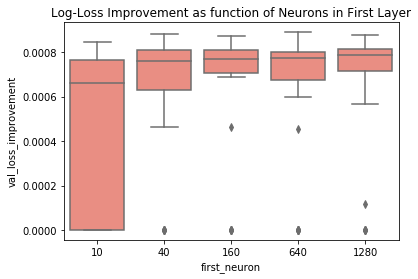

In [43]:
import seaborn as sns
metric = 'first_neuron'
ax = sns.boxplot(x=metric, y="val_loss_improvement", data=df.reset_index(),color='salmon')
ax.set_title('Log-Loss Improvement as function of Neurons in First Layer')
# Increasing neurons have a strong, positive impact

Text(0.5,1,'Log-Loss Improvement as function of hidden_neuron')

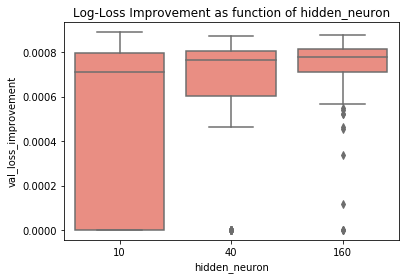

In [44]:
metric = 'hidden_neuron'
ax = sns.boxplot(x=metric, y="val_loss_improvement", data=df.reset_index(),color='salmon')
ax.set_title(f'Log-Loss Improvement as function of {metric}')
# Again, bigger seems to be better

Text(0.5,1,'Log-Loss Improvement as function of hidden_layers')

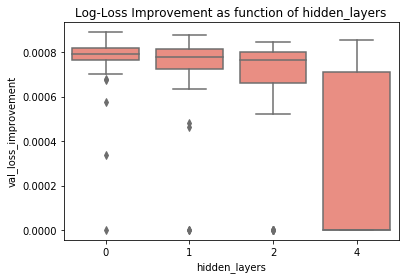

In [45]:
metric = 'hidden_layers'
ax = sns.boxplot(x=metric, y="val_loss_improvement", data=df.reset_index(),color='salmon')
ax.set_title(f'Log-Loss Improvement as function of {metric}')
# Surprisingly, no hidden layers is consistently best

Text(0.5,1,'Log-Loss Improvement as function of dropout')

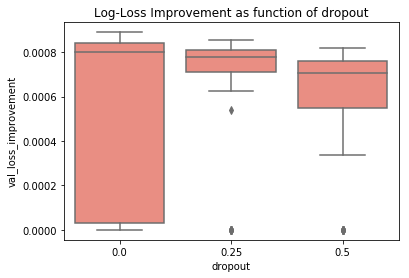

In [49]:
metric = 'dropout'
ax = sns.boxplot(x=metric, y="val_loss_improvement", data=df.reset_index(),color='salmon')
ax.set_title(f'Log-Loss Improvement as function of {metric}')
# Really interestingly, dropout seemed to hurt matters.  

Text(0.5,1,'Validation Loss as function of batch_size')

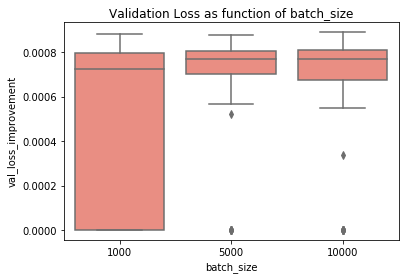

In [50]:
metric = 'batch_size'
ax = sns.boxplot(x=metric, y="val_loss_improvement", data=df.reset_index(),color='salmon')
ax.set_title(f'Validation Loss as function of {metric}')
# Generally, larger batch sizes don't hurt (and train faster)

As a total aside, we can also measure relationships which all assume, but may not know for certain.  Below, I've plotted the number of epochs before early stopping (when the model begins to overfit and get worse on validation) vs. network size.  Unsurprisingly, it takes larger networks longer to converge.  The relationship seems pretty close to logarithmic relative to "links" between nodes.  

Text(0.5,1,'Epochs Until Convergence vs. Link Count')

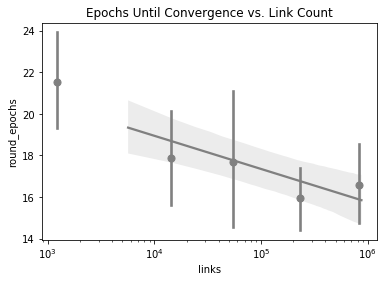

In [51]:
ax = sns.regplot(x='links', y="round_epochs",x_bins=5,logx=True ,data=df[['links','round_epochs']],color='grey')
ax.set_xscale('log')

ax.set_title(f'Epochs Until Convergence vs. Link Count')

### Multivariate Effects
Of course, reality is non-linear and we can't think about each of these parameters in isolation.  Below are a few ways to look at pairs of factors that are logically related. 

Text(0.5,1,'Log-Loss Improvement for Varying Shapes')

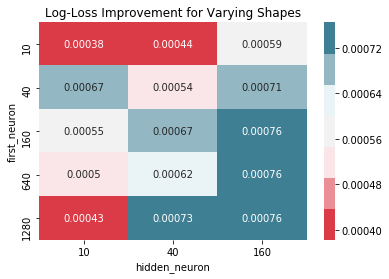

In [60]:
df_grid = df.reset_index().groupby(["first_neuron", "hidden_neuron"]).val_loss_improvement.mean().unstack()
ax = sns.heatmap(data=df_grid,cmap = (sns.diverging_palette(10, 220, sep=80, n=7)),annot=True)
ax.set_title('Log-Loss Improvement for Varying Shapes')
# Unsurprisingly, bigger on both layer types is better.  

Text(0.5,1,'Log-Loss Improvement for Varying Shapes')

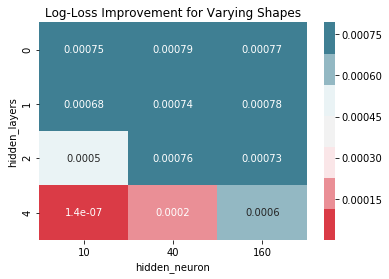

In [61]:
df_grid = df.reset_index().groupby(["hidden_layers", "hidden_neuron"]).val_loss_improvement.mean().unstack()
ax = sns.heatmap(data=df_grid,cmap = (sns.diverging_palette(10, 220, sep=80, n=7)),annot=True)
ax.set_title('Log-Loss Improvement for Varying Shapes')


Text(0.5,1,'Log-Loss Improvement vs Dropout/Size')

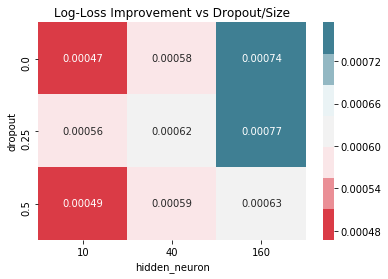

In [66]:
df_grid = df.reset_index().groupby(["dropout", "hidden_neuron"]).val_loss_improvement.mean().unstack()
ax = sns.heatmap(data=df_grid,cmap = (sns.diverging_palette(10, 220, sep=80, n=7)),annot=True)
ax.set_title('Log-Loss Improvement vs Dropout/Size')
# Surprisingly, dropout didn't help even at larger geometries

In [ ]:
metric = 'hidden_layers'
ax = sns.boxplot(x=metric, y="val_loss", data=df.reset_index(),color='salmon')
ax.set_title(f'Validation Loss as function of {metric}')
# Very interestingly, no hidden layers is MUCH better.  Possibly a consequence of
# some deep models with too few neurons to properly represent data

### Relative Importance of Features
With so many findings, where do we start?  I'll run a quick random forest regression model and test the relative significance of each hyperparameter in overall model performance:

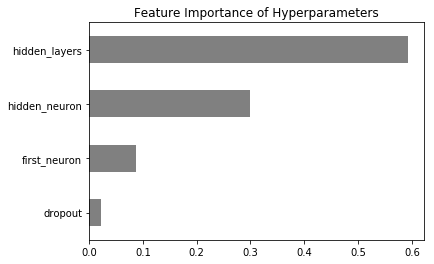

In [70]:
from sklearn.preprocessing import MinMaxScaler
X = df[['first_neuron','hidden_neuron','hidden_layers','dropout']]
scaler = MinMaxScaler()
y = scaler.fit_transform(df[['val_loss_improvement']])

from sklearn.ensemble import RandomForestRegressor

reg = RandomForestRegressor(max_depth=3,n_estimators=100)
reg.fit(X,y)
pd.Series(reg.feature_importances_,index=X.columns).\
sort_values(ascending=True).plot.barh(color='grey',title='Feature Importance of Hyperparameters')

It appears that number of hidden layers is - by far - most important, followed by size of hidden layers.  Of course, if we drop to zero hidden layers, then first layer size become supremely important.  

For the next hyperparameter sweep, I'll focus on larger layer sizes - and fewer layers.  

In [2]:
## Experiment 2: 
from keras.models import Sequential
from keras.layers import Dropout, Dense
from keras.callbacks import TensorBoard
from talos.model.early_stopper import early_stopper


# track performance on tensorboard
tensorboard = TensorBoard(log_dir='./logs',
                 histogram_freq=0,batch_size=10000,
                 write_graph=False, 
                 write_images=False)


# (1) Define dict of parameters to try
p = {'first_neuron':[100,200,400,800,1600,3200],
     'hidden_neuron':[100, 200, 400, 800 ],
     'hidden_layers':[0,1],
     'batch_size': [10000],
     'optimizer': ['adam'],
     'kernel_initializer': ['uniform'], #'normal'
     'epochs': [100], # increased in case larger dimensions take longer to train
     'dropout': [0.0,0.25],
     'last_activation': ['sigmoid']}

# (2) create a function which constructs a compiled keras model object
def numerai_model(x_train, y_train, x_val, y_val, params):
    print(params)

    model = Sequential()
    
    
    ## initial layer
    model.add(Dense(params['first_neuron'], input_dim=x_train.shape[1],
                    activation='relu',
                    kernel_initializer = params['kernel_initializer'] ))
    model.add(Dropout(params['dropout']))
    
    ## hidden layers
    for i in range(params['hidden_layers']):
        print (f"adding layer {i+1}")
        model.add(Dense(params['hidden_neuron'], activation='relu',
                    kernel_initializer=params['kernel_initializer']))
        model.add(Dropout(params['dropout']))
    
    
    ## final layer
    model.add(Dense(1, activation=params['last_activation'],
                    kernel_initializer=params['kernel_initializer']))
    
    model.compile(loss='binary_crossentropy', 
                  optimizer=params['optimizer'],
                  metrics=['acc'])
    
    history = model.fit(x_train, y_train, 
                        validation_data=[x_val, y_val],
                        batch_size=params['batch_size'],
                        epochs=params['epochs'],
                        callbacks=[tensorboard,early_stopper(params['epochs'], patience=10)], #,ta.live(),
                        verbose=0)
    return history, model

# (3) Run a "Scan" using the params and function created above

t = ta.Scan(x=X_train.values,
            y=y_train.values,
            model=numerai_model,
            params=p,
            grid_downsample=1.00,
            dataset_name='numerai_example',
            experiment_no='2')


There we have it.  Is this optimal?  Almost certainly not.  But I now have a much better understanding of how the model performs at various geometries - and have spent relatively little time performing plug-and-chug parameter tweaking.  

At this point, I'll build and train a single model with parameter values that showed most successful in the hyperparameter sweeps.  

There are infinite possibilities for further optimizations, which I won't explore here.  For instance:
* RELU vs ELU unit types
* Various geometries of topography (funnel-shaped, etc...)
* Initializer type
* Optimizer type
* Feature extraction/selection methods (e.g., PCA)

I'd welcome readers' insights in the discussion thread on which levers you've found most useful in optimizing (fully connected) network architectures.  

## Final Model

Baseline Log-Loss (guess 0.5): 0.6931471805599451
Best Log-Loss (validation): 0.6923070976435054


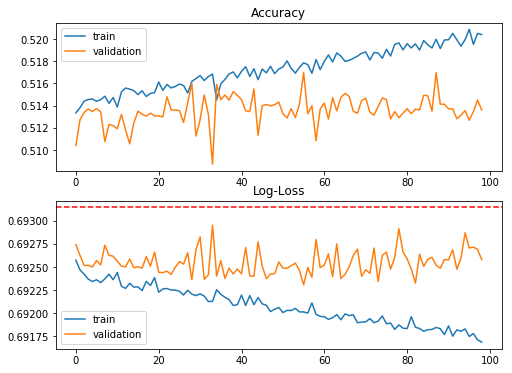

In [50]:
## Final Model

from keras.models import Sequential
from keras.layers import Dropout,Dense
from keras.callbacks import TensorBoard

# track performance on tensorboard
tensorboard = TensorBoard(log_dir='./logs',
                 histogram_freq=0,batch_size=10000,
                 write_graph=False, 
                 write_images=False)

def build_final_model():
    model = Sequential()

    ## initial layer
    model.add(Dense(800, input_dim=X_train.shape[1],
                    activation='relu',
                    kernel_initializer = 'uniform' ))
    ## hidden layers
    model.add(Dense(100, activation='relu',
                kernel_initializer='uniform'))
    ## final layer
    model.add(Dense(1, activation='sigmoid',
                    kernel_initializer='uniform'))
    
    model.compile(loss='binary_crossentropy', 
                  optimizer='adam',
                  metrics=['acc'])
    
    return model

model = build_final_model()

history = model.fit(X_train, y_train, 
                    validation_data=[X_val, y_val],
                    batch_size=10000,
                    epochs=100,
                    callbacks=[tensorboard], #,ta.live(),
                    verbose=0)


fig,axs = plt.subplots(2,figsize=(8,6))

acc_train = history.history['acc']
acc_val = history.history['val_acc']

loss_train = history.history['loss']
loss_val = history.history['val_loss']

print('Baseline Log-Loss (guess 0.5): 0.6931471805599451')
print(f'Best Log-Loss (validation): {pd.Series(loss_val).min()}')


pd.Series(acc_train[1:]).rename('train').plot(legend=True,title='Accuracy',ax=axs[0])
pd.Series(acc_val[1:]).rename('validation').plot(legend=True,ax=axs[0])

pd.Series(loss_train[1:]).rename('train').plot(legend=True,title='Log-Loss',ax=axs[1])
pd.Series(loss_val[1:]).rename('validation').plot(legend=True,ax=axs[1])
axs[1].axhline(y=base_loss, color='red',linestyle='--')



## One last thing...
If you've found this post helpful, please consider subscribing to the email list to be notified of future posts (email addresses will only be used for this purpose...).  

You can also follow me on [twitter](https://twitter.com/data2alpha) and forward to a friend or colleague who may find this topic interesting.  